**1)Business Context**

Organizations like Veridia are seeking ways to optimize recruitment and operational strategies by leveraging data-driven insights from their candidate resume collections. Effective analysis of resume data can help identify skill gaps, improve candidate-job matching, and streamline hiring processes.

**2)Objective**

The goal of this project is to analyze and visualize a large resume dataset, uncovering patterns and actionable insights to enhance recruitment decision-making. The analysis will involve data cleaning, exploratory statistics, visualizations, and potentially predictive modeling for candidate categorization or job readiness assessment.

**3)Dataset**

This project uses the publicly available Resume Dataset from Kaggle, which contains thousands of anonymized resumes across various job categories, roles, and skillsets. The dataset is suitable for comprehensive data analytics tasks such as textual analysis, skill frequency mapping, and machine learning for recruitment applications.

**4)Expected Outcomes**

Cleaned and organized resume data ready for business analytics.

Statistical summaries and visualizations of key resume attributes.

Insights into skill trends, candidate distribution, and hiring patterns.

Recommendations for improving recruitment strategies based on data evidence.

Predictive models for automating candidate categorization and screening.

In [1]:
# Core data libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For text processing and ML
import re
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
# Load the Resume.csv file directly since it's uploaded in Colab environment
df = pd.read_csv('Resume.csv')

# Show first few records to understand structure
df.head()


ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

In [3]:
# Dataset shape and column data types
print("Dataset shape:", df.shape)
print("Columns and types:\n", df.dtypes)

# Sample random rows for text preview
df.sample(5)


Dataset shape: (2484, 4)
Columns and types:
 ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object


ID                                         Resume_str  \
2414  11137306           SIMULATOR TECHNICIAN           Summar...   
1896  18669563           PROJECT ACCOUNTANT       Professional...   
234   27372171           INFORMATION TECHNOLOGY SPECIALIST/SYS...   
1245  25525152           EDITORIAL ASSISTANT       Summary    ...   
1204  37818861           CONSTRUCTION CONSULTANT       Summary...   

                                            Resume_html  \
2414  <div class="fontsize fontface vmargins hmargin...   
1896  <div class="fontsize fontface vmargins hmargin...   
234   <div class="fontsize fontface vmargins hmargin...   
1245  <div class="fontsize fontface vmargins hmargin...   
1204  <div class="fontsize fontface vmargins hmargin...   

                    Category  
2414                AVIATION  
1896              ACCOUNTANT  
234   INFORMATION-TECHNOLOGY  
1245           DIGITAL-MEDIA  
1204              CONSULTANT

In [4]:
# Basic info summary
df.info()

# Descriptive stats for textual columns
df.describe(include='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


Resume_str  \
count                                                2484   
unique                                               2482   
top              STOREKEEPER II       Professional Sum...   
freq                                                    2   

                                              Resume_html  \
count                                                2484   
unique                                               2482   
top     <div class="fontsize fontface vmargins hmargin...   
freq                                                    2   

                      Category  
count                     2484  
unique                      24  
top     INFORMATION-TECHNOLOGY  
freq                       120

The dataset contains 2400+ resumes, meant to categorize resumes into job labels such as IT, HR, Designer, Teacher, Finance, and more.
Each record includes a unique ID, resume text (string and HTML), and category labels.
This step loads the dataset file Resume.csv into a Pandas DataFrame and inspects its shape, data types, and sample records before cleaning and analysis.

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download resources if not already available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added this line

# Stopword set
stop_words = set(stopwords.words('english'))

# Precompile regex patterns
RE_HTML = re.compile(r'<.*?>')
RE_SPACES = re.compile(r'\s+')
RE_CLASSIFY = re.compile(r'[^a-zA-Z0-9\s]')        # allow numbers for tagging
RE_SKILLS = re.compile(r'[^a-zA-Z0-9\s\+\#]')      # allow numbers + C++/C#

def clean_text_classification(text: str) -> str:
    """
    Cleaning for ML classification (TF-IDF, embeddings).
    - Lowercase
    - Remove HTML
    - Replace numbers with "num <NUM>" (keeps actual number + generic token)
    - Remove punctuation
    - Remove stopwords
    """
    text = text.lower()
    text = RE_HTML.sub(" ", text)
    text = re.sub(r'(\d+)', r' \1 <NUM> ', text)    # keep number + tag
    text = RE_CLASSIFY.sub(" ", text)
    text = RE_SPACES.sub(" ", text).strip()

    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)


def clean_text_skills(text: str) -> str:
    """
    Cleaning for skill extraction / keyword search.
    - Lowercase
    - Remove HTML
    - Keep numbers as-is
    - Keep acronyms like C++, C#
    - Do NOT remove stopwords (to preserve job titles)
    """
    text = text.lower()
    text = RE_HTML.sub(" ", text)
    text = RE_SKILLS.sub(" ", text)                 # keeps letters, numbers, +, #
    text = RE_SPACES.sub(" ", text).strip()

    tokens = word_tokenize(text)
    tokens = [w for w in tokens if len(w) > 1 or w in ["c", "r"]]
    return " ".join(tokens)


# Apply both versions
df['resume_clean_classify'] = df['Resume_str'].apply(clean_text_classification)
df['resume_clean_skills'] = df['Resume_str'].apply(clean_text_skills)

# Show sample
print(df[['Resume_str', 'resume_clean_classify', 'resume_clean_skills']].sample(3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                             Resume_str  \
2200           PROJECT COORDINATOR         Highlight...   
892            SENIOR EXERCISE SPECIALIST & SPORTS A...   
398                PRESCHOOL TEACHER       Professio...   

                                  resume_clean_classify  \
2200  project coordinator highlights skill summary w...   
892   senior exercise specialist sports recreation c...   
398   preschool teacher professional summary efficie...   

                                    resume_clean_skills  
2200  project coordinator highlights skill summary h...  
892   senior exercise specialist sports and recreati...  
398   preschool teacher professional summary efficie...  


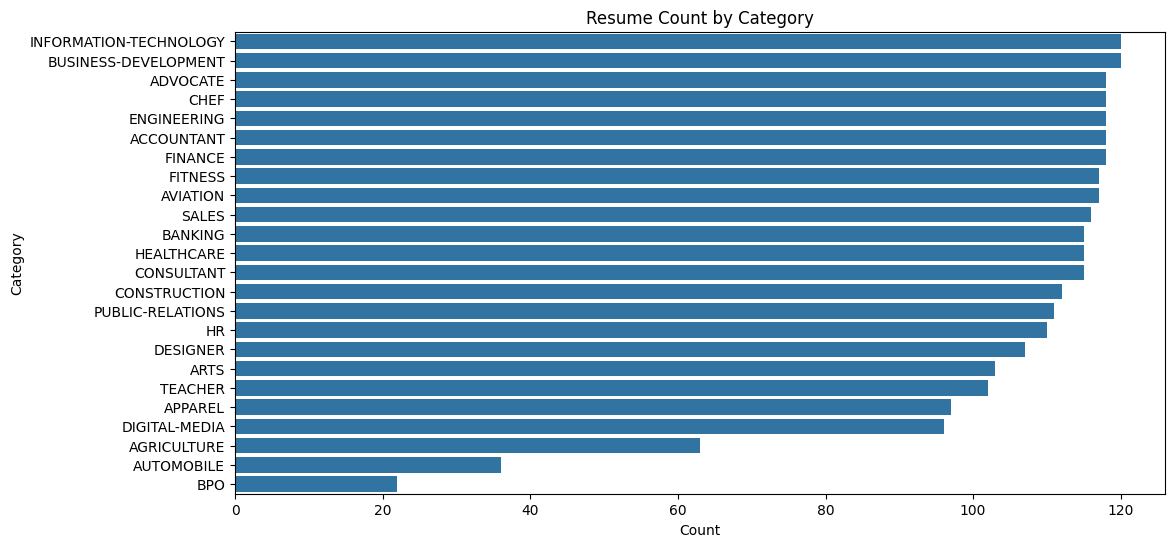

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Category', order=df['Category'].value_counts().index)
plt.title('Resume Count by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


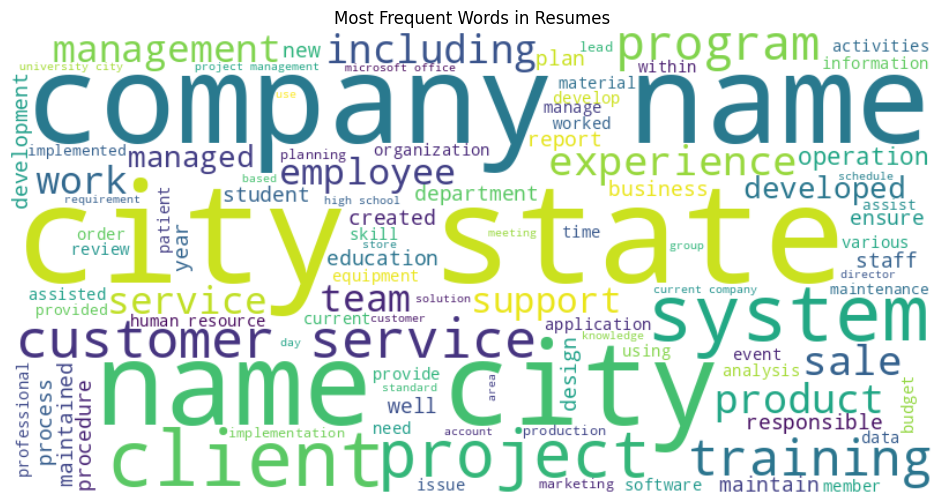

In [9]:
from wordcloud import WordCloud
all_text = ' '.join(df['resume_clean_skills'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Resumes")
plt.show()


In this section, the raw resume texts are cleaned by removing HTML tags, special characters, and common English stopwords to prepare for analysis. The category distribution is visualized to understand the volume of resumes per job category. A word cloud highlights frequently occurring skills and terms across all resumes, providing initial insights into prevalent candidate skills and focus areas.

In [10]:
from collections import Counter

def get_top_words(category, n=15):
    texts = df[df['Category'] == category]['cleaned_resume']
    all_words = ' '.join(texts).split()
    top_words = Counter(all_words).most_common(n)
    return pd.DataFrame(top_words, columns=['Word', 'Frequency'])

import matplotlib.pyplot as plt

# Example: Top words in 'INFORMATION-TECHNOLOGY' category
top_it_words = get_top_words('HR')

plt.figure(figsize=(10,6))
sns.barplot(x='Frequency', y='Word', data=top_it_words, palette='viridis')
plt.title('Top 15 Words in INFORMATION-TECHNOLOGY Resumes')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


KeyError: 'cleaned_resume'

In [ ]:
df['word_count'] = df['cleaned_resume'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Category', y='word_count')
plt.xticks(rotation=90)
plt.title('Distribution of Resume Text Length (Word Count) by Category')
plt.ylabel('Word Count')
plt.xlabel('Category')
plt.show()


In [ ]:
# Create a simplified presence matrix for a selected small set of common words and categories
top_categories = df['Category'].value_counts().index[:8]  # take top 8 categories

common_words = ['management', 'experience', 'project', 'data', 'development', 'team', 'software', 'design', 'sales', 'training']

heatmap_data = {}

for cat in top_categories:
    category_words = df[df['Category'] == cat]['cleaned_resume'].str.cat(sep=' ').split()
    word_counts = Counter(category_words)
    heatmap_data[cat] = [word_counts.get(word, 0) for word in common_words]

import seaborn as sns
import pandas as pd

heatmap_df = pd.DataFrame.from_dict(heatmap_data, orient='index', columns=common_words)
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Word Frequency Heatmap across Top 8 Categories')
plt.ylabel('Category')
plt.xlabel('Words')
plt.show()


This section explores category-specific skill and keyword distributions to understand domain-specific language in resumes. Bar plots visualize prominent words for categories like HR, highlighting industry-relevant skills and terms. Word count boxplots show variability in resume length across occupations, potentially indicating differences in detail level or experience. The heatmap cross-compares key skills across top categories, revealing shared or unique terminology patterns that can aid targeted recruitment strategies.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# Step 1: Detect outliers using IQR (for reporting & separate analysis)
Q1 = df['word_count'].quantile(0.25)
Q3 = df['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['word_count'] < lower_bound) | (df['word_count'] > upper_bound)]
non_outliers = df[(df['word_count'] >= lower_bound) & (df['word_count'] <= upper_bound)]

print(f"Number of outlier resumes: {len(outliers)}")
print(f"Number of non-outlier resumes: {len(non_outliers)}")

# Outlier vs Non-outlier category distribution
print("Outlier category distribution:")
print(outliers['Category'].value_counts(normalize=True))
print("\nNon-outlier category distribution:")
print(non_outliers['Category'].value_counts(normalize=True))

KeyError: 'word_count'

In [ ]:
# Step 2: Visualize distribution with all data
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Category', y='word_count')
plt.title('Resume Word Count Distribution by Category (Including Outliers)')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Step 3: Non-parametric Kruskal-Wallis test for differences across categories (including outliers)
groups = [df[df['Category'] == cat]['word_count'] for cat in df['Category'].unique()]
kruskal_result = kruskal(*groups)

print('Kruskal-Wallis H-statistic:', kruskal_result.statistic)
print('Kruskal-Wallis p-value:', kruskal_result.pvalue)

# Interpretation:
# A p-value < 0.05 indicates significant difference in resume lengths across categories

The Kruskal-Wallis test shows a significant difference in resume lengths across job categories (H = 101.26, p < 0.001), indicating word count varies meaningfully by category.

In [ ]:
# Step 4: Outlier-specific visualization to investigate further
plt.figure(figsize=(10,5))
sns.countplot(y=outliers['Category'], order=outliers['Category'].value_counts().index)
plt.title('Frequency of Outlier Resumes by Category')
plt.show()

The code first identifies outliers in resume word count using the interquartile range (IQR) method but keeps all data for further analysis.

Category distributions for outliers vs non-outliers are examined to understand if outliers are biased towards specific job roles.

The word count distribution boxplot visualizes all resumes including outliers, preserving real-world variation.

For hypothesis testing, the Kruskal-Wallis non-parametric test is used to assess if resume lengths differ significantly across job categories, as it is robust to outliers and non-normal data.

Finally, outlier resume categories are visualized separately to enable focused recruitment insights for exceptionally detailed profiles.

In [12]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from scipy.stats import kruskal
from wordcloud import WordCloud

# ==============================================================================
# PHASE 1: Predictive Modeling (Step 7 & 8)
# ==============================================================================

print("\n" + "="*50)
print("Starting Predictive Modeling Pipeline")
print("="*50)

# --- Feature and Target Definition ---
# Use classification-cleaned text for modeling
X = df['resume_clean_classify']
y = df['Category']

# 1. Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 3. Feature Vectorization (TF-IDF)
# Define custom stop words for TfidfVectorizer
custom_stop_words_set = set(ENGLISH_STOP_WORDS)
additional_stop_words = {
    'yrs', 'experience', 'company', 'work', 'job', 'skill', 'like', 'etc',
    'management', 'data', 'projects', 'project', 'client', 'clients',
    'service', 'development', 'business'
}
custom_stop_words_set.update(additional_stop_words)
custom_stop_words_list = list(custom_stop_words_set)

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=custom_stop_words_list,
    ngram_range=(1, 2)   # added bigrams for better context capture
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

target_names = le.inverse_transform(np.arange(num_classes))

# --- STEP 7: MNB Baseline Model ---
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_pred_mnb = mnb.predict(X_test_vec)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)

print(f"\n--- 1. Multinomial Naive Bayes (MNB) Baseline Model ---")
print(f"Overall Accuracy: {accuracy_mnb:.4f}")
print("\nClassification Report (MNB):")
print(classification_report(y_test, y_pred_mnb, target_names=target_names, zero_division=0))

# --- STEP 8: LinearSVC Advanced Model ---
svc = LinearSVC(random_state=42, max_iter=5000)
svc.fit(X_train_vec, y_train)
y_pred_svc = svc.predict(X_test_vec)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

print(f"\n--- 2. Linear Support Vector Classifier (LinearSVC) Model ---")
print(f"Overall Accuracy: {accuracy_svc:.4f}")
print("LinearSVC is the recommended production model.")
print("\nClassification Report (LinearSVC):")
print(classification_report(y_test, y_pred_svc, target_names=target_names, zero_division=0))



Starting Predictive Modeling Pipeline

--- 1. Multinomial Naive Bayes (MNB) Baseline Model ---
Overall Accuracy: 0.5714

Classification Report (MNB):
                        precision    recall  f1-score   support

            ACCOUNTANT       0.53      0.88      0.66        24
              ADVOCATE       0.29      0.42      0.34        24
           AGRICULTURE       1.00      0.08      0.14        13
               APPAREL       0.50      0.05      0.10        19
                  ARTS       1.00      0.14      0.25        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.83      0.62      0.71        24
               BANKING       0.86      0.52      0.65        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.41      0.83      0.55        24
                  CHEF       0.83      0.79      0.81        24
          CONSTRUCTION       0.71      0.77      0.74        22
            CONS

TF-IDF Matrix created: 2484 samples, 5000 features.
Calculating SSE for Elbow Method (K=5 to K=15)...


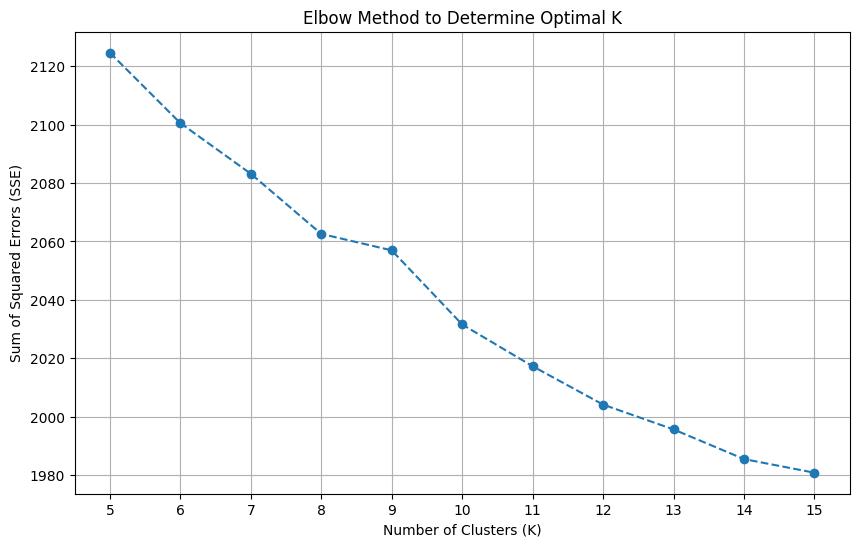

Selected optimal_k = 10 for further analysis.
--------------------------------------------------
K-Means clustering applied with K=10. Cluster labels stored in 'Skill_Trend'.
--------------------------------------------------


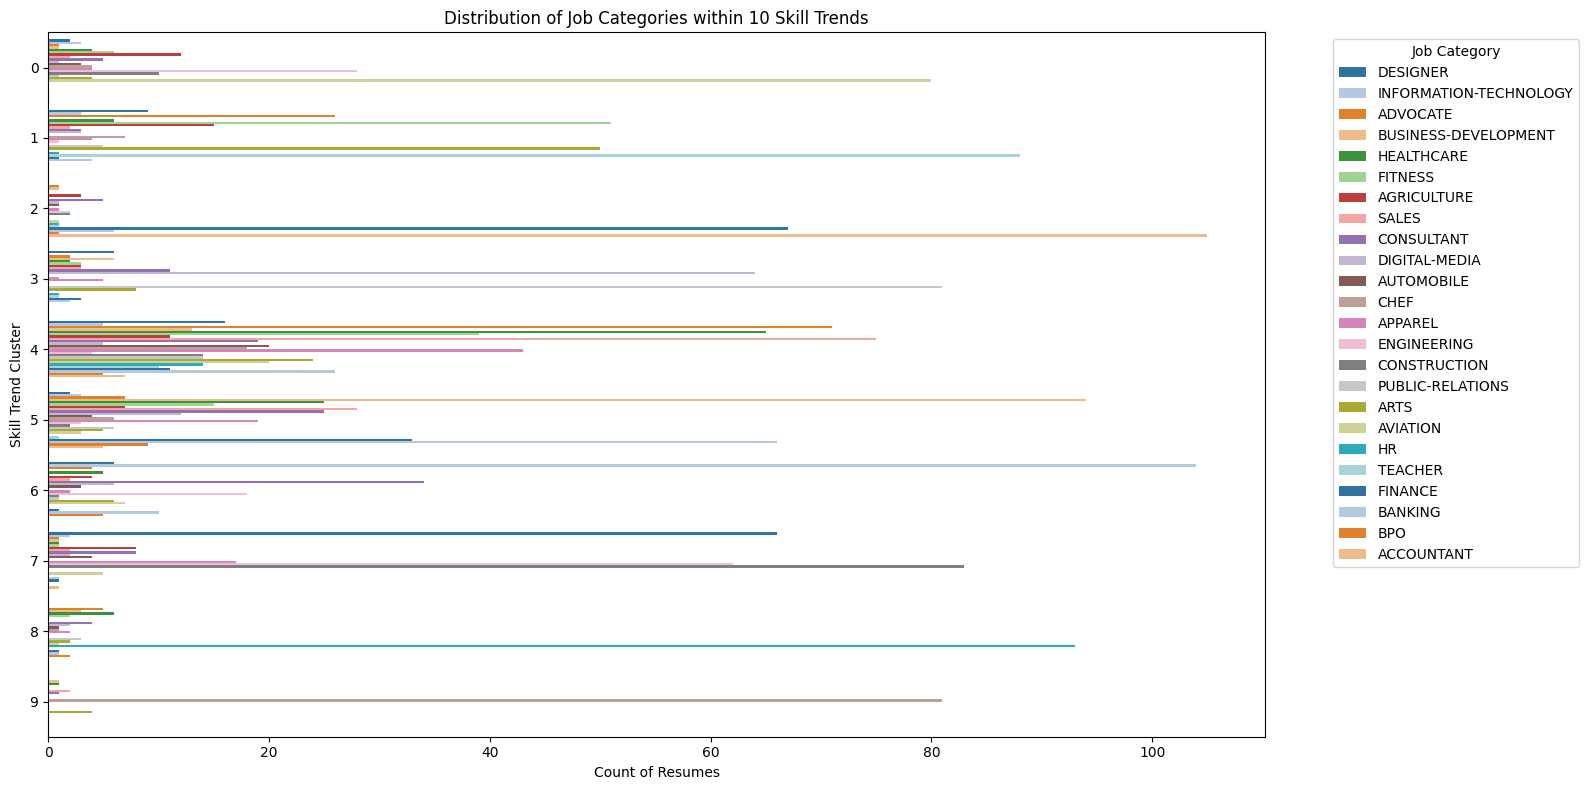

Top 10 words for each of the 10 Skill Trends:
Trend 0: AVIATION & ENGINEERING
  Top Words: equipment, aviation, aircraft, maintenance, safety, state, city, city state, systems, electrical
  -> Interpretation: 'Trend 0: Data Science & AI' (ML/statistical terms dominate)
----------------------------------------------------------------------
Trend 1: TEACHER & FITNESS
  Top Words: students, teacher, student, state, city, fitness, city state, children, school, learning
  -> Interpretation: 'Trend 1: Web & Software Development' (Programming languages/frameworks)
----------------------------------------------------------------------
Trend 2: ACCOUNTANT & FINANCE
  Top Words: accounting, financial, accounts, tax, accountant, ledger, finance, general ledger, monthly, payroll
----------------------------------------------------------------------
Trend 3: PUBLIC-RELATIONS & DIGITAL-MEDIA
  Top Words: marketing, media, public, public relations, social media, relations, social, digital, content, c

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Ensure the dataframe is loaded
df = pd.DataFrame(df)

# -----------------------------
# Step 0: Feature Extraction
# -----------------------------
# Use skill-cleaned resumes for clustering
X_text = df['resume_clean_skills']

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 2)  # capture unigrams + bigrams
)
X_vec = vectorizer.fit_transform(X_text)
print(f"TF-IDF Matrix created: {X_vec.shape[0]} samples, {X_vec.shape[1]} features.")

# -----------------------------
# Step 1: Determine Optimal Clusters (Elbow Method)
# -----------------------------
sse = {}
K_range = range(5, 16)  # K from 5 to 15

print("Calculating SSE for Elbow Method (K=5 to K=15)...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_vec)
    sse[k] = kmeans.inertia_

# Plot SSE
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

# For demonstration, we pick K=10
optimal_k = 10
print(f"Selected optimal_k = {optimal_k} for further analysis.")
print("-" * 50)

# -----------------------------
# Step 2: Apply K-Means
# -----------------------------
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_model.fit(X_vec)
cluster_labels = kmeans_model.labels_

df['Skill_Trend'] = cluster_labels
print(f"K-Means clustering applied with K={optimal_k}. Cluster labels stored in 'Skill_Trend'.")
print("-" * 50)

# -----------------------------
# Step 3: Visualize Trends
# -----------------------------
plt.figure(figsize=(16, 8))
sns.countplot(
    y='Skill_Trend',
    hue='Category',
    data=df,
    palette='tab20'
)
plt.title(f'Distribution of Job Categories within {optimal_k} Skill Trends')
plt.xlabel('Count of Resumes')
plt.ylabel('Skill Trend Cluster')
plt.legend(title='Job Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# -----------------------------
# Step 4: Analyze Trends - Top Words
# -----------------------------
feature_names = vectorizer.get_feature_names_out()
centroid_matrix = kmeans_model.cluster_centers_

print(f"Top 10 words for each of the {optimal_k} Skill Trends:")
print("=" * 70)

for i in range(optimal_k):
    top_indices = centroid_matrix[i].argsort()[::-1][:10]
    top_words = [feature_names[idx] for idx in top_indices]

    # Top 3 categories in this cluster
    top_categories = df[df['Skill_Trend'] == i]['Category'].value_counts().nlargest(3).index.tolist()

    print(f"Trend {i}: {' & '.join(top_categories[:2])}")
    print(f"  Top Words: {', '.join(top_words)}")

    # Optional interpretation
    if i == 0:
        print(f"  -> Interpretation: 'Trend 0: Data Science & AI' (ML/statistical terms dominate)")
    elif i == 1:
        print(f"  -> Interpretation: 'Trend 1: Web & Software Development' (Programming languages/frameworks)")
    print("-" * 70)


In [14]:
# -----------------------------
# Example Resumes for Prediction
# -----------------------------
example_resumes = [
    # Engineering & Construction
    "Seeking a lead role in engineering large construction sites. Expertise includes on-site safety inspections, project planning, and equipment maintenance.",

    # Data Science & AI
    "Experienced in Python, R, and machine learning algorithms. Developed predictive models for customer churn and sales forecasting.",

    # Web & Software Development
    "Front-end developer proficient in HTML, CSS, JavaScript, React, and Node.js. Designed responsive web applications and APIs.",

    # Finance & Accounting
    "Certified accountant with 7 years of experience in bookkeeping, auditing, tax preparation, and financial reporting.",

    # Healthcare & Fitness
    "Registered nurse with expertise in patient care, administering medications, and maintaining health records in clinical settings.",

    # HR & Admin
    "HR specialist skilled in recruitment, employee engagement, and performance management. Familiar with HR software and compliance.",

    # Sales & Business Development
    "Business development manager with experience generating leads, client relationship management, and driving revenue growth.",

    # Digital Media & Design
    "Graphic designer proficient in Adobe Photoshop, Illustrator, and video editing. Developed branding and digital campaigns for clients.",

    # Agriculture & Apparel
    "Agriculture consultant with expertise in crop management, soil analysis, and sustainable farming techniques.",

    # Automobile & Aviation
    "Mechanical engineer specialized in vehicle maintenance, engine diagnostics, and aerodynamics. Experience with auto and aerospace projects."
]

# Move the necessary imports and variable definitions from cell AjhkjWiwKUlX
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# --- K-Means (Unsupervised Skill Trends) ---
# Features: resume_clean_skills
X_skills_text = df['resume_clean_skills']
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)
)
X_vec = vectorizer.fit_transform(X_skills_text)

# Apply K-Means
optimal_k = 10
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_model.fit(X_vec)

# Map cluster labels to human-readable trends (example, update after top words)
skill_trend_map = {
    1: "Teaching & Fitness",                     # students, teacher, fitness, school, children
    2: "Accounting & Finance",                   # accounting, financial, ledger, payroll
    3: "Public Relations & Digital Media",      # marketing, social media, digital, communications
    4: "Sales & Customer Service",              # customer, service, sales, company
    5: "Business Development & Banking",        # sales, business, marketing, management
    6: "IT & Consulting",                        # network, server, technology, software, systems
    7: "Construction & Design",                  # construction, design, project, engineering
    8: "HR & Healthcare",                        # hr, employee, human resources, recruitment, benefits
    9: "Culinary & Arts",                        # chef, food, kitchen, culinary, restaurant
}


# -----------------------------
# Predict Skill Trend for Each Resume
# -----------------------------
# Ensure clean_text_skills is available (assuming it's defined in a previous cell)
# from the latest notebook state, the cell with id 'R4ltLzXk5K0f' defines this function, which is before this cell.

for idx, resume in enumerate(example_resumes):
    cleaned_resume = clean_text_skills(resume)
    resume_vec = vectorizer.transform([cleaned_resume])
    predicted_label = kmeans_model.predict(resume_vec)[0]
    predicted_name = skill_trend_map.get(predicted_label, f"Trend {predicted_label}")

    print(f"\nExample {idx+1}:")
    print(f"Resume Snippet: '{resume[:60]}...'")
    print(f"Predicted Skill Trend Label: {predicted_label}")
    print(f"Predicted Skill Trend Name: **{predicted_name}**")


Example 1:
Resume Snippet: 'Seeking a lead role in engineering large construction sites....'
Predicted Skill Trend Label: 7
Predicted Skill Trend Name: **Construction & Design**

Example 2:
Resume Snippet: 'Experienced in Python, R, and machine learning algorithms. D...'
Predicted Skill Trend Label: 5
Predicted Skill Trend Name: **Business Development & Banking**

Example 3:
Resume Snippet: 'Front-end developer proficient in HTML, CSS, JavaScript, Rea...'
Predicted Skill Trend Label: 6
Predicted Skill Trend Name: **IT & Consulting**

Example 4:
Resume Snippet: 'Certified accountant with 7 years of experience in bookkeepi...'
Predicted Skill Trend Label: 2
Predicted Skill Trend Name: **Accounting & Finance**

Example 5:
Resume Snippet: 'Registered nurse with expertise in patient care, administeri...'
Predicted Skill Trend Label: 4
Predicted Skill Trend Name: **Sales & Customer Service**

Example 6:
Resume Snippet: 'HR specialist skilled in recruitment, employee engagement, a...'
Predic

In [15]:
# -----------------------------
# 1️⃣ Prepare Vectorizers and Models
# -----------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# --- LinearSVC (Supervised) ---
# Features: resume_clean_classify
X = df['resume_clean_classify']
y = df['Category']

# Label encode
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define custom stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stop_words_set = set(ENGLISH_STOP_WORDS)
additional_stop_words = {
    'yrs', 'experience', 'company', 'work', 'job', 'skill', 'like', 'etc',
    'management', 'data', 'projects', 'project', 'client', 'clients',
    'service', 'development', 'business'
}
custom_stop_words_set.update(additional_stop_words)
custom_stop_words_list = list(custom_stop_words_set)

# TF-IDF vectorizer for LinearSVC
vectorizer_svc = TfidfVectorizer(
    max_features=5000,
    stop_words=custom_stop_words_list,
    ngram_range=(1,2)
)
X_train_vec = vectorizer_svc.fit_transform(X_train)
X_test_vec = vectorizer_svc.transform(X_test)

# Train LinearSVC
svc = LinearSVC(random_state=42, max_iter=5000)
svc.fit(X_train_vec, y_train)

# --- K-Means (Unsupervised Skill Trends) ---
# Features: resume_clean_skills
X_skills_text = df['resume_clean_skills']
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)
)
X_vec = vectorizer.fit_transform(X_skills_text)

# Apply K-Means
optimal_k = 10
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_model.fit(X_vec)

# Map cluster labels to human-readable trends (example, update after top words)
skill_trend_map = {
    1: "Teaching & Fitness",                     # students, teacher, fitness, school, children
    2: "Accounting & Finance",                   # accounting, financial, ledger, payroll
    3: "Public Relations & Digital Media",      # marketing, social media, digital, communications
    4: "Sales & Customer Service",              # customer, service, sales, company
    5: "Business Development & Banking",        # sales, business, marketing, management
    6: "IT & Consulting",                        # network, server, technology, software, systems
    7: "Construction & Design",                  # construction, design, project, engineering
    8: "HR & Healthcare",                        # hr, employee, human resources, recruitment, benefits
    9: "Culinary & Arts",                        # chef, food, kitchen, culinary, restaurant
}



# -----------------------------
# 2️⃣ Combined Prediction Function
# -----------------------------
def predict_resume_insights(resume_text):
    """
    Input: raw resume text
    Output: predicted job category (LinearSVC) and skill trend (K-Means)
    """
    # Clean text
    cleaned_classify = clean_text_classification(resume_text)
    cleaned_skills = clean_text_skills(resume_text)

    # Vectorize
    X_svc_vec = vectorizer_svc.transform([cleaned_classify])
    X_kmeans_vec = vectorizer.transform([cleaned_skills])

    # Predict Category (LinearSVC)
    pred_category_label = svc.predict(X_svc_vec)[0]
    pred_category_name = le.inverse_transform([pred_category_label])[0]

    # Predict Skill Trend (K-Means)
    pred_trend_label = kmeans_model.predict(X_kmeans_vec)[0]
    pred_trend_name = skill_trend_map.get(pred_trend_label, f"Trend {pred_trend_label}")

    return {
        "Resume_Snippet": resume_text[:60] + "...",
        "Predicted_Category": pred_category_name,
        "Predicted_Skill_Trend": pred_trend_name
    }

# -----------------------------
# 3️⃣ Test Examples
# -----------------------------
example_resumes = [
    "Seeking a lead role in engineering large construction sites. Expertise includes on-site safety inspections, project planning, and equipment maintenance",
    "Experienced in Python, R, and machine learning algorithms. Developed predictive models for customer churn and sales forecasting",
    "Front-end developer proficient in HTML, CSS, JavaScript, React, and Node.js. Designed responsive web applications and APIs",
    "Certified accountant with 7 years of experience in bookkeeping, auditing, tax preparation, and financial reporting",
    "Registered nurse with expertise in patient care, administering medications, and maintaining health records in clinical settings"
]

predictions = [predict_resume_insights(resume) for resume in example_resumes]

# Display as DataFrame
results_df = pd.DataFrame(predictions)
print(results_df)


                                      Resume_Snippet    Predicted_Category  \
0  Seeking a lead role in engineering large const...          CONSTRUCTION   
1  Experienced in Python, R, and machine learning...  BUSINESS-DEVELOPMENT   
2  Front-end developer proficient in HTML, CSS, J...            CONSULTANT   
3  Certified accountant with 7 years of experienc...            ACCOUNTANT   
4  Registered nurse with expertise in patient car...            HEALTHCARE   

            Predicted_Skill_Trend  
0           Construction & Design  
1  Business Development & Banking  
2                 IT & Consulting  
3            Accounting & Finance  
4        Sales & Customer Service  


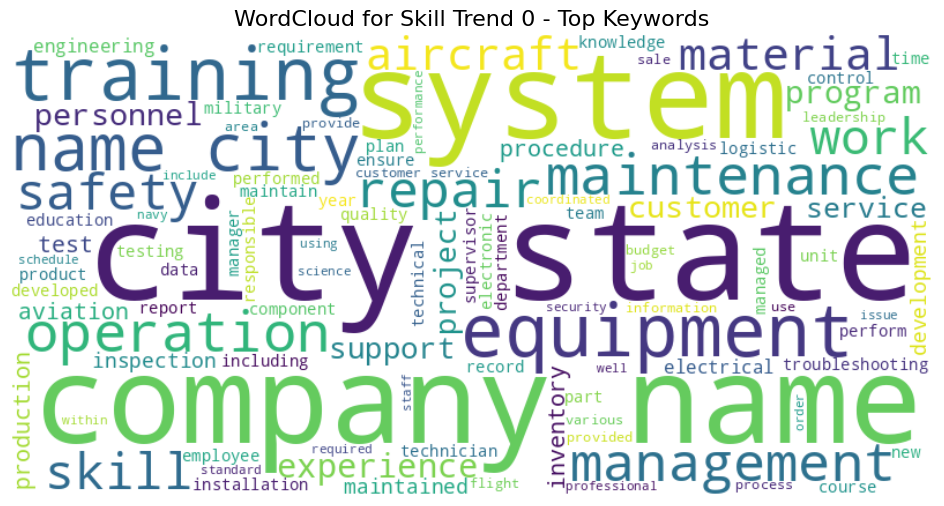

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


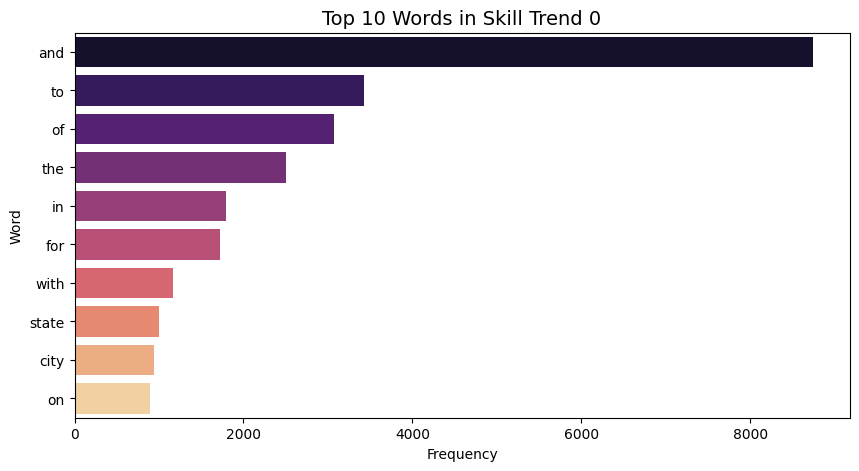

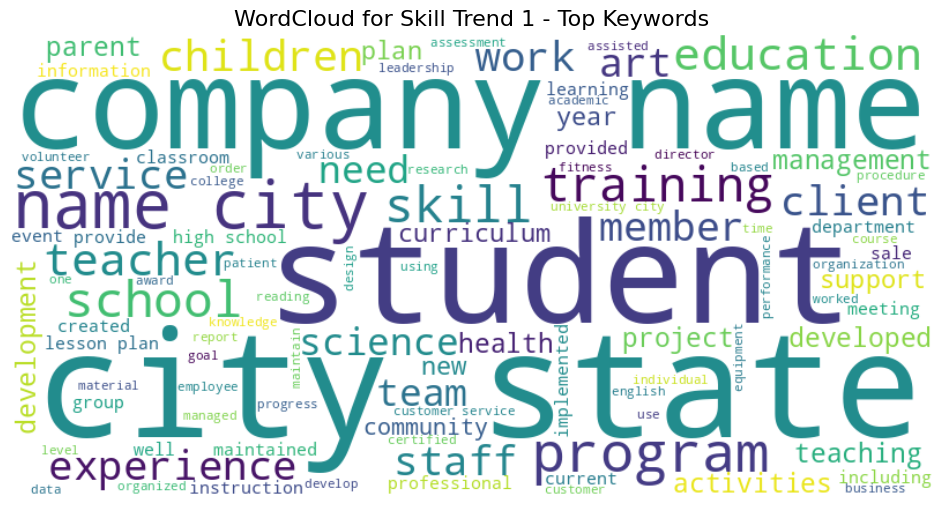

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


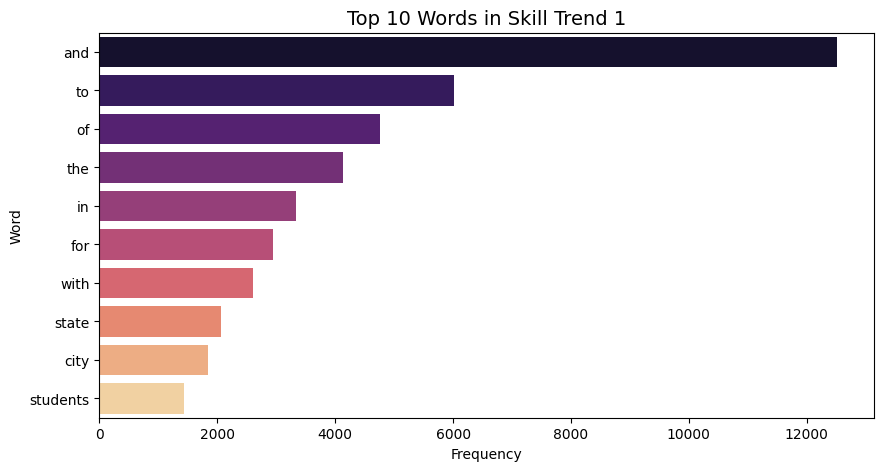

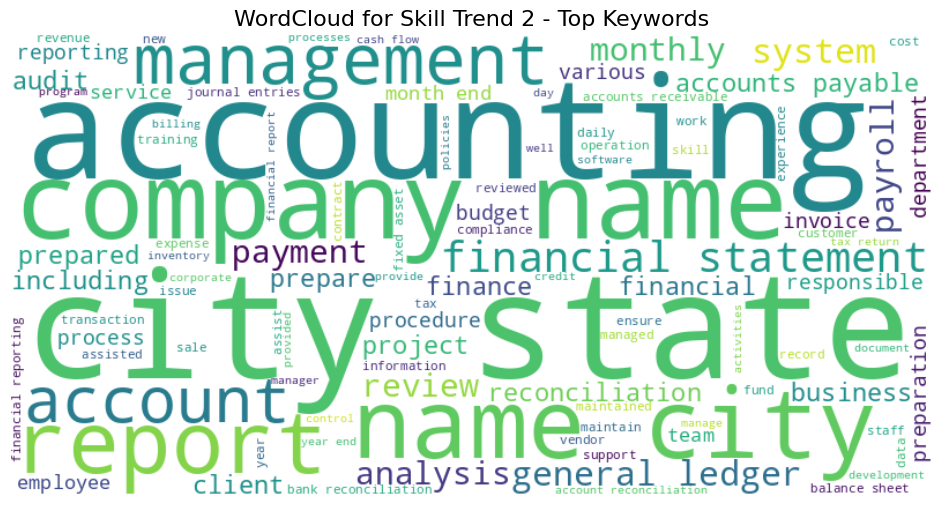

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


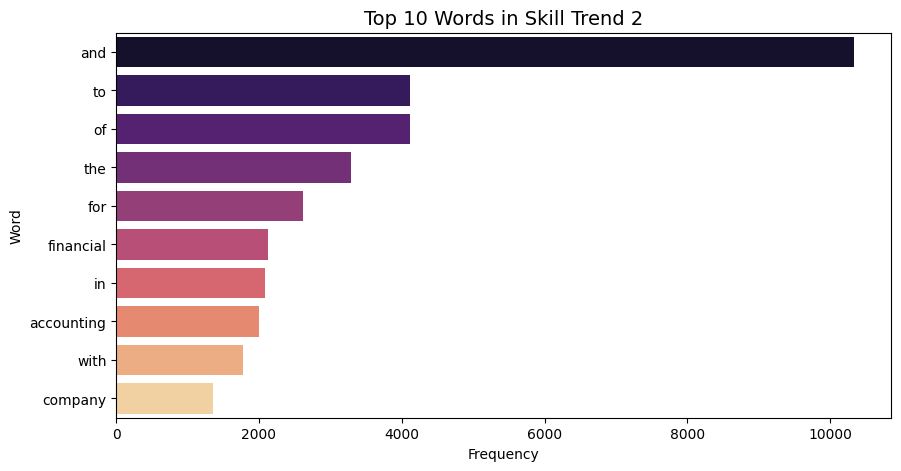

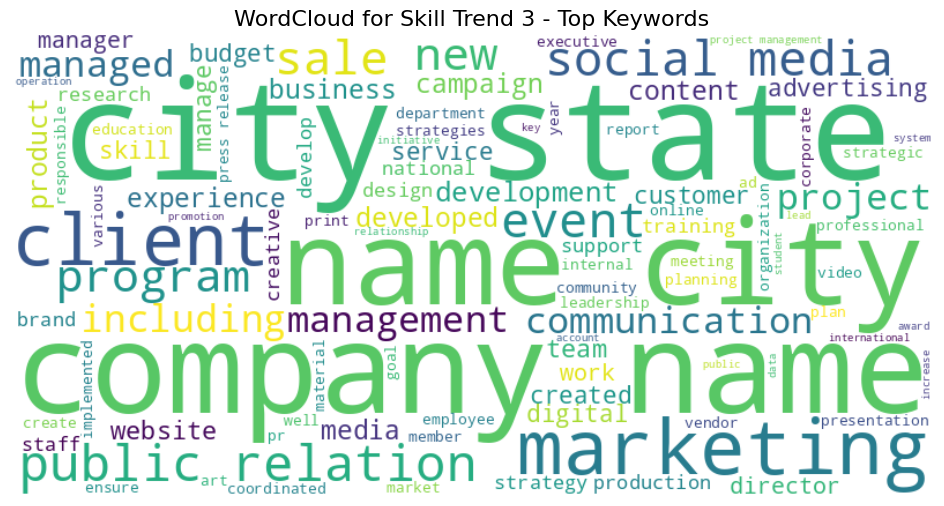

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


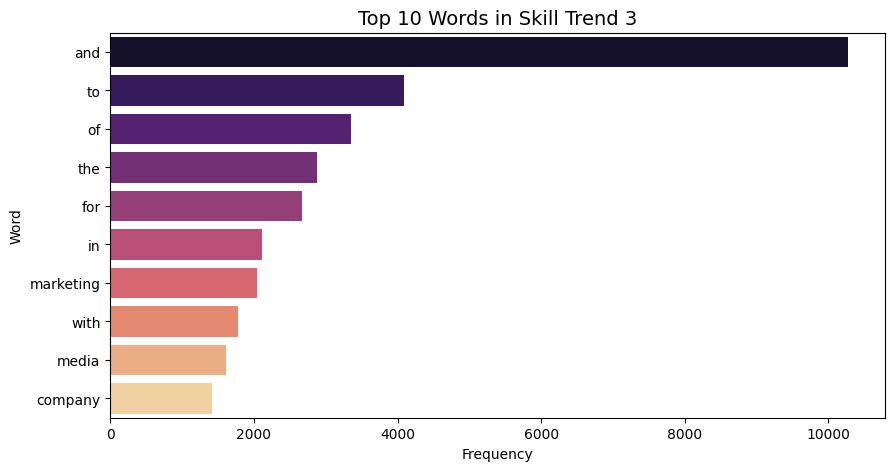

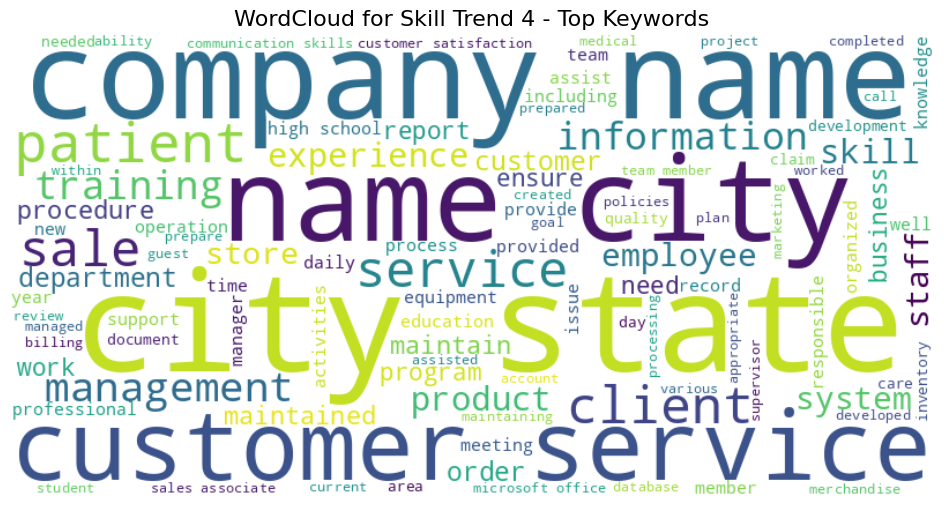

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


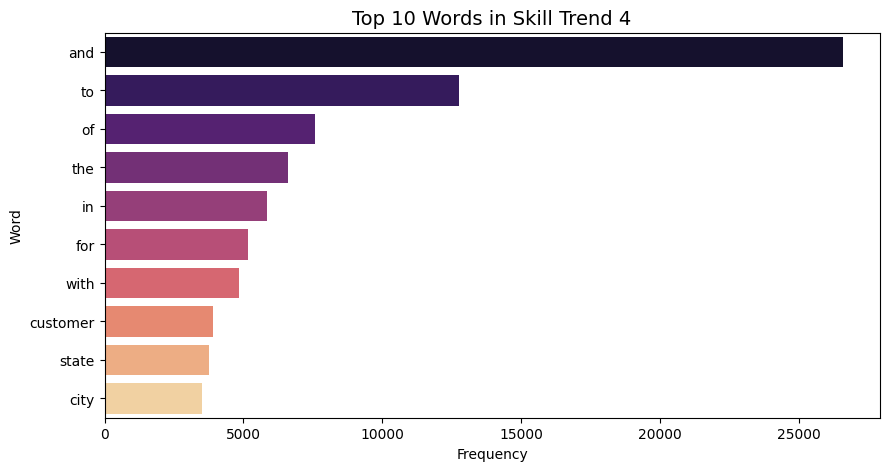

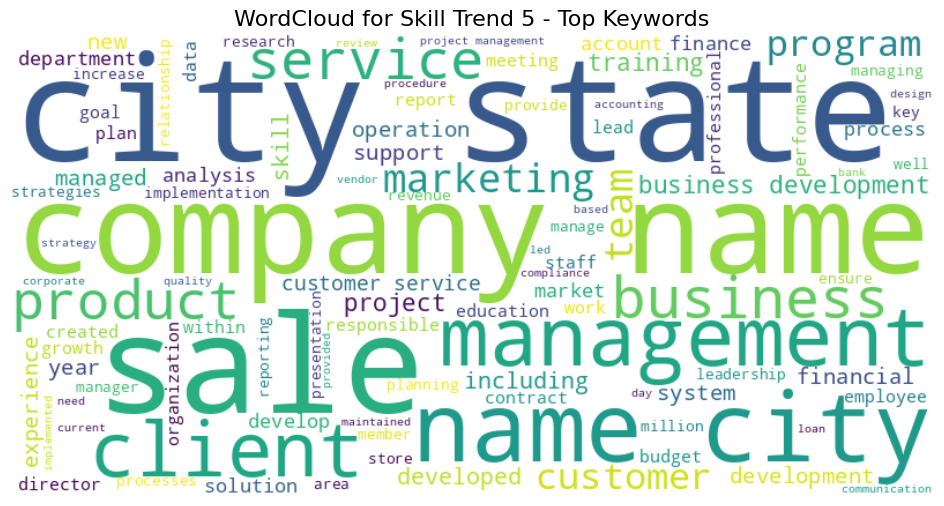

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


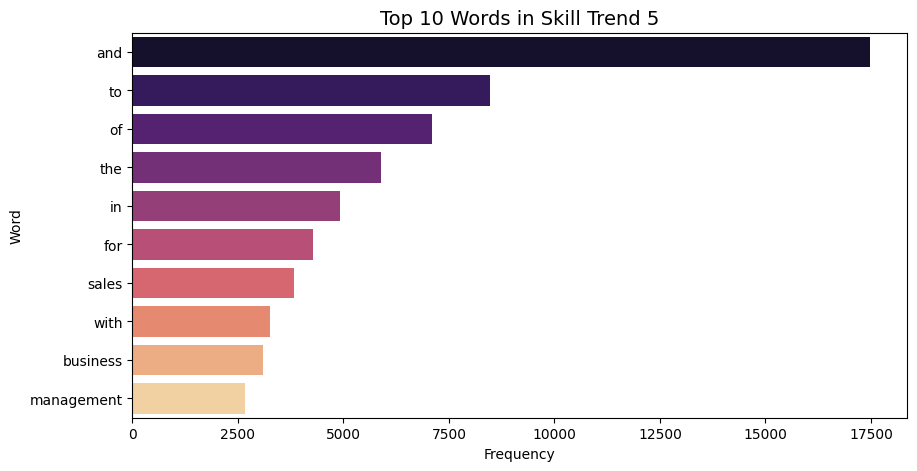

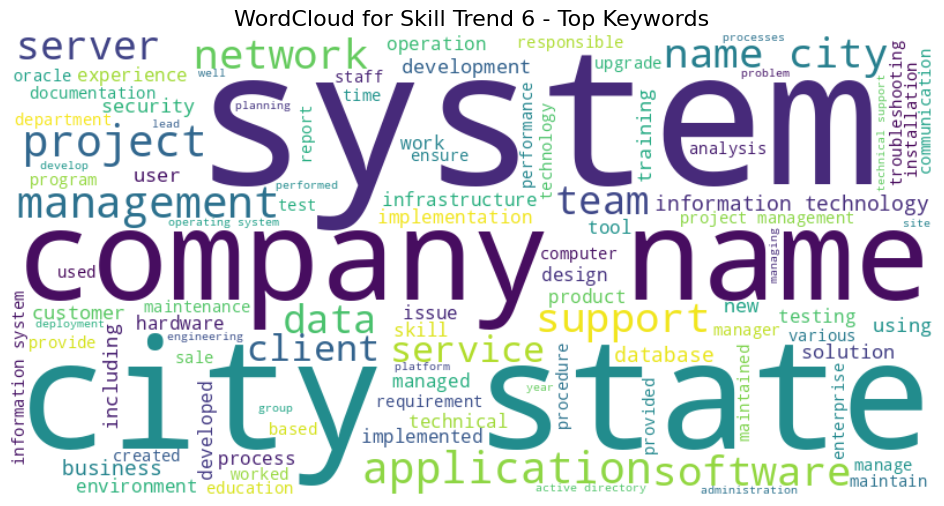

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


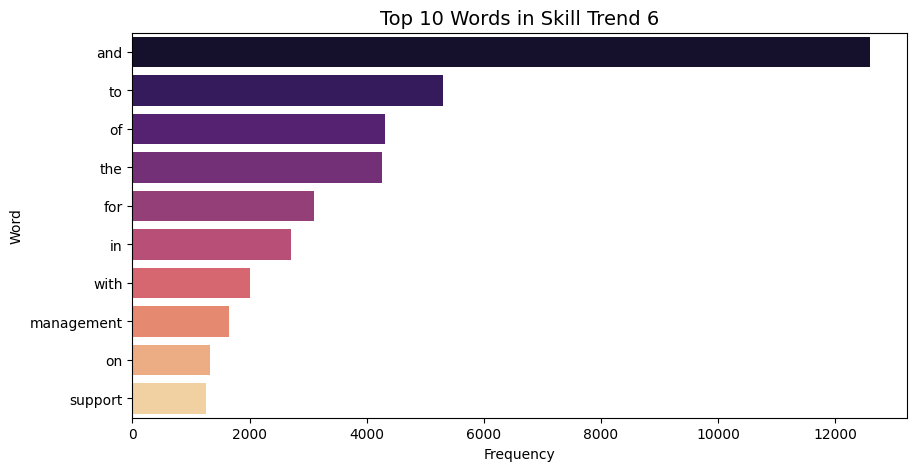

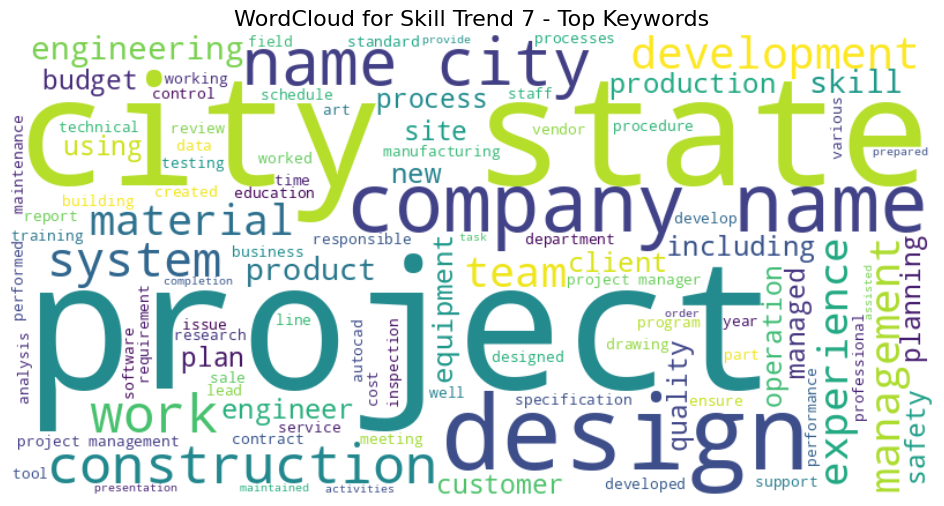

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


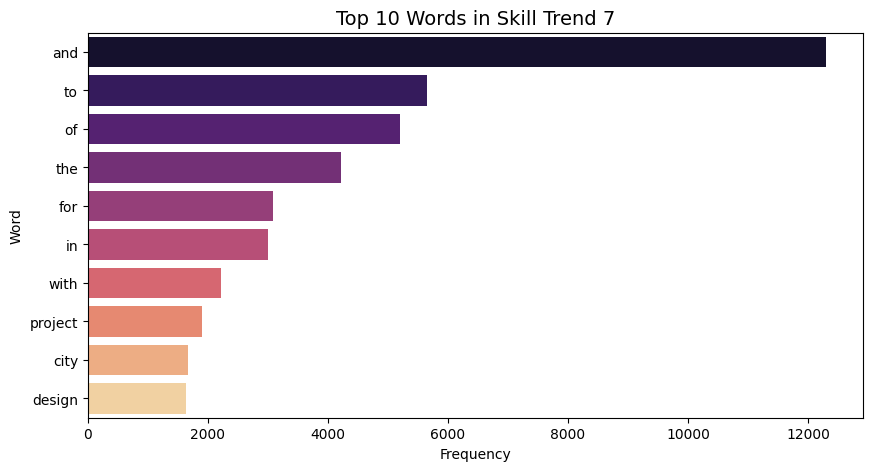

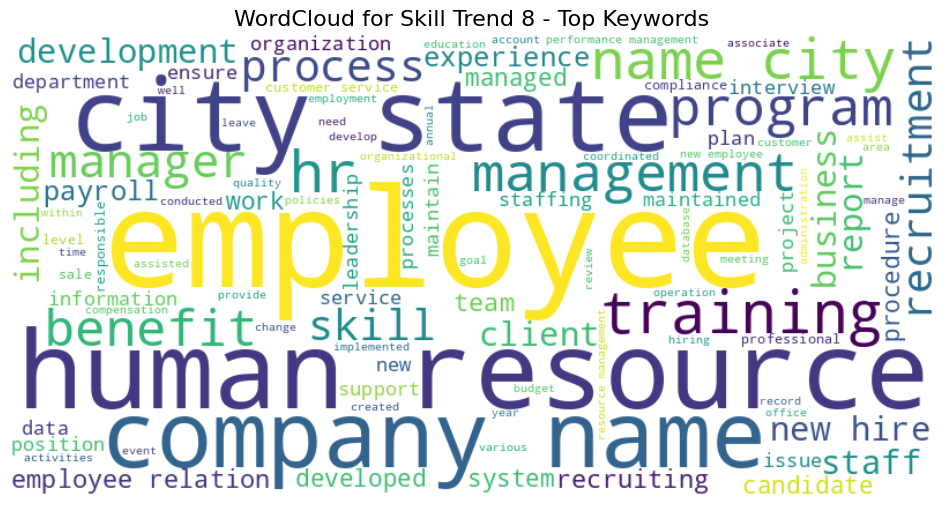

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


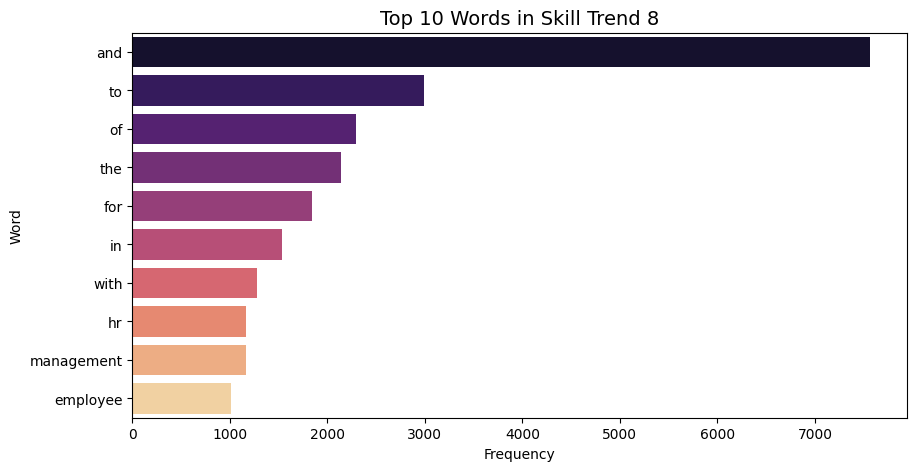

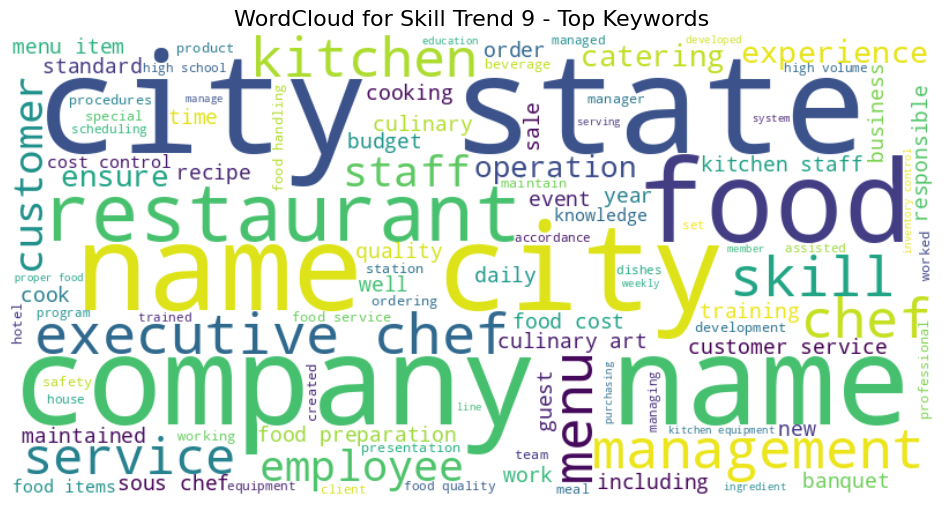

/tmp/ipython-input-1884269631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


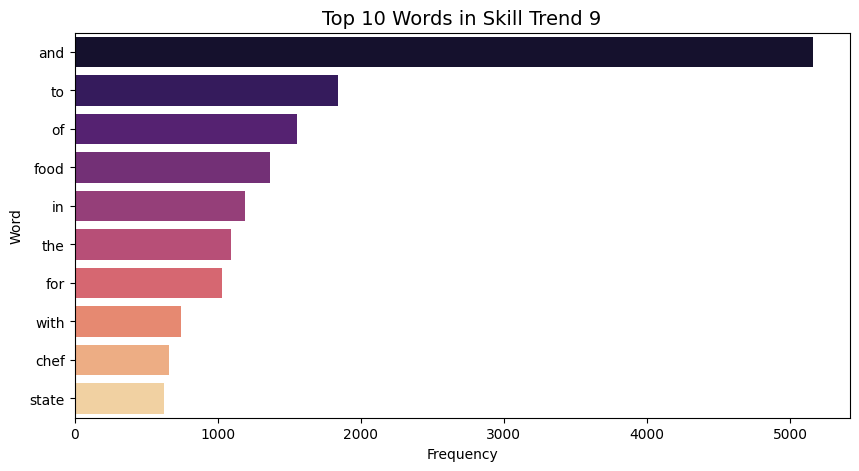

In [16]:
from wordcloud import WordCloud

# -----------------------------
# Step 5: Cluster-wise WordClouds & Top Skills
# -----------------------------
for i in range(optimal_k):
    cluster_text = " ".join(df[df['Skill_Trend'] == i]['resume_clean_skills'])
    if not cluster_text.strip():
        continue  # skip empty clusters

    # Generate WordCloud
    wc = WordCloud(
        width=800, height=400, background_color='white',
        max_words=100, colormap='viridis'
    ).generate(cluster_text)

    # Plot WordCloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Skill Trend {i} - Top Keywords', fontsize=16)
    plt.show()

    # Top 10 skills/words by frequency
    word_list = cluster_text.split()
    word_freq = Counter(word_list)
    top_10 = word_freq.most_common(10)
    words, counts = zip(*top_10)

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette='magma')
    plt.title(f'Top 10 Words in Skill Trend {i}', fontsize=14)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()


In [17]:
import pandas as pd

# Load dataset
df = pd.read_csv("Resume.csv")

# Add word_count column
df["word_count"] = df["Resume_str"].apply(lambda x: len(str(x).split()))

# Group by category and compute summary stats
summary_table = df.groupby("Category")["word_count"].agg(["count", "mean", "median"]).sort_values("count", ascending=False)

# Get top-10 categories
top10_mean_median = summary_table[["mean", "median"]].head(10)

print("Top 10 Categories with Mean and Median Word Count:\n")
print(top10_mean_median)


Top 10 Categories with Mean and Median Word Count:

                              mean  median
Category                                  
INFORMATION-TECHNOLOGY  926.583333   839.0
BUSINESS-DEVELOPMENT    775.025000   746.0
ACCOUNTANT              800.008475   748.5
ADVOCATE                848.500000   756.5
CHEF                    797.008475   770.0
ENGINEERING             837.550847   783.5
FINANCE                 811.762712   751.0
AVIATION                791.196581   754.0
FITNESS                 723.034188   725.0
SALES                   689.767241   696.0


✅ Accuracy: 0.710261569416499

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.71      0.83      0.77        24
              ADVOCATE       0.61      0.71      0.65        24
           AGRICULTURE       0.89      0.62      0.73        13
               APPAREL       0.60      0.32      0.41        19
                  ARTS       0.57      0.38      0.46        21
            AUTOMOBILE       1.00      0.29      0.44         7
              AVIATION       0.82      0.75      0.78        24
               BANKING       0.78      0.78      0.78        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.56      0.79      0.66        24
                  CHEF       0.81      0.71      0.76        24
          CONSTRUCTION       0.83      0.86      0.84        22
            CONSULTANT       0.67      0.35      0.46        23
              DESIGNER       0.87      0.95      

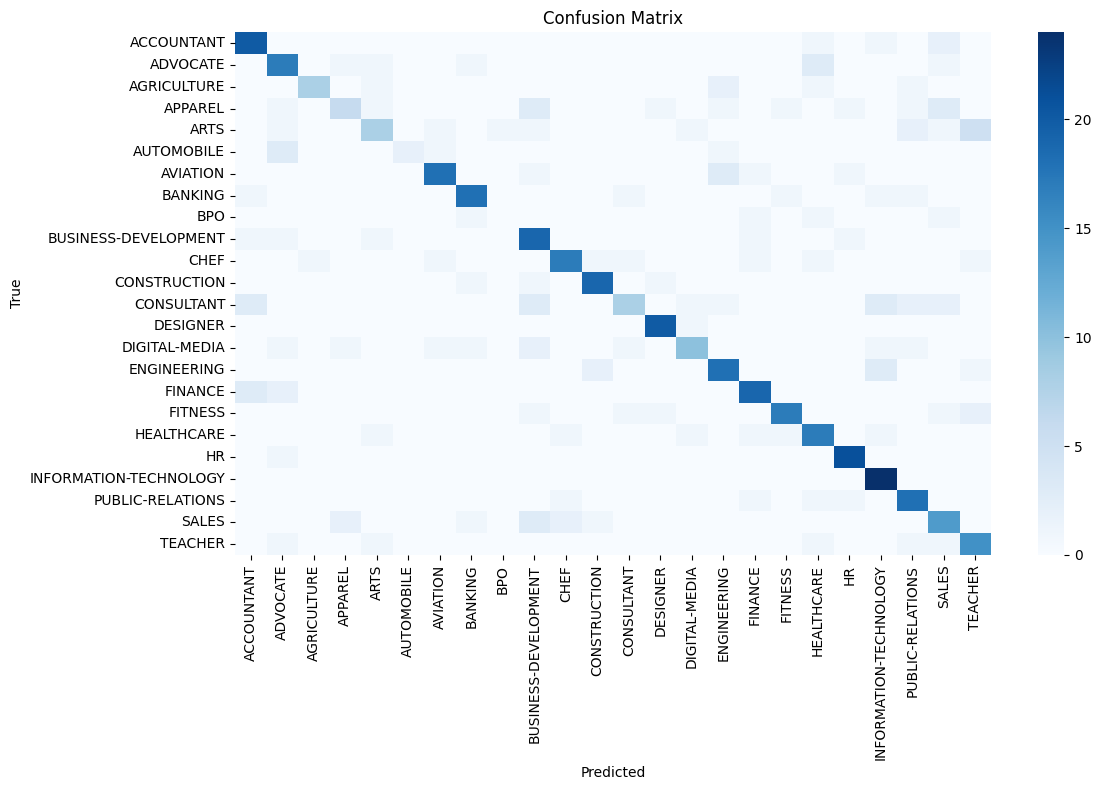


Sample Predictions:
['HR' 'BUSINESS-DEVELOPMENT' 'ADVOCATE' 'FINANCE' 'ACCOUNTANT']


In [18]:
# ===============================
# Resume Classification Pipeline
# ===============================

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Load Data
# -------------------------------
df = pd.read_csv("Resume.csv")

X = df["Resume_str"].astype(str)
y = df["Category"]

# -------------------------------
# Encode labels
# -------------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -------------------------------
# Train / Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# -------------------------------
# Build TF-IDF + LinearSVC pipeline
# -------------------------------
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("clf", LinearSVC(random_state=42))
])

# -------------------------------
# Train
# -------------------------------
pipeline.fit(X_train, y_train)

# -------------------------------
# Evaluate
# -------------------------------
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -------------------------------
# Save pipeline + label encoder
# -------------------------------
joblib.dump((pipeline, le), "resume_pipeline_joblib.pkl")

# -------------------------------
# Prediction function
# -------------------------------
def predict_resume_insights(texts):
    """
    Predict categories for a list of resume texts.
    """
    preds = pipeline.predict(texts)
    labels = le.inverse_transform(preds)
    return labels

# -------------------------------
# Example Usage
# -------------------------------
sample_resumes = X_test.sample(5, random_state=1)
print("\nSample Predictions:")
print(predict_resume_insights(sample_resumes))


In [19]:
# ================================
# Save pipeline + LabelEncoder
# ================================
import joblib

# Save both the pipeline and label encoder together
joblib.dump((pipeline, le), "resume_pipeline_joblib.pkl")


# ================================
# Define prediction function
# ================================
def predict_resume_insights(texts, model_path="resume_pipeline_joblib.pkl"):
    """
    Predict categories for a list of resume texts.

    Parameters
    ----------
    texts : list of str
        Resume strings to classify
    model_path : str
        Path to saved pipeline + label encoder joblib file

    Returns
    -------
    list of str
        Predicted categories
    """
    # Load the trained pipeline + encoder
    pipe, label_enc = joblib.load(model_path)
    preds = pipe.predict(texts)
    labels = label_enc.inverse_transform(preds)
    return labels


# ================================
# Example usage
# ================================
sample_texts = [
    "Experienced software engineer skilled in Python, Java, and cloud computing.",
    "Expert in financial analysis, accounting, and investment banking."
]

print(predict_resume_insights(sample_texts))
# -> e.g. ['INFORMATION-TECHNOLOGY', 'FINANCE']


['BUSINESS-DEVELOPMENT' 'BANKING']
